# Algorithms.md

-------

-------

# Describe Approach

## Algorithm

**Description:** 

Divide image into 64 equally sized regions.  These regions will be categories into 3 groups: Corner Regions (CR), Border Regions (BR), and Inner Regions (IR), and the number of regions in each group is 4, 24, and 36 respectively.  Now we have to calculate the mapping function for the histogram of each of the regions, which we can do by scaling the CDF of each histogram by $\frac{N - 1}{M}$ where $M$ is the number of pixels in a region, and $N$ is the number of different grayscale pixel intensities.  This mapping function is used to convert each histogram to approximate the probability density funciton of a uniform distribution.  

Since just doing AHE can lead to overaplimication of noise, we perform contrast limiting on each of the regional histograms to prevent this.  We accomplish this by calculating a clip limit $\beta$ for which to clip all the histograms.  I.e. we limit the maxiumum number of counts for each grayscale pixel intensity value to $\beta$.  All extra counts beyond this limit are uniformly distributed among the grayscale values with counts less than the clip limit.  

And the last step is to modify the mapping for each pixel by scaling it according to a weighted-sum of its four nearest regions.

[//]: <> (In normal histogram equalization, the standard procedure is to re-map grayscales of an image so that the resulting histogram approximates that of a uniform distribution.  This has limitations though, as the distributions of grayscales, i.e. histograms, can change from one region of the image to another, so an adaptive histogram equilization technique may produce better results.)

[//]: <> (The contrast limiting part of the transformation has to do with preventing the overamplification of noise that adaptive histogram equalization can give rise to.  By contrast limiting each regional histogram, )

**Inputs:** 
  1. The array of an image.
  2. The clip limit, which is the contrast limit for each grayscale value (default is 40)
  3. Tile grid size, which is a tuple of the dimensions that the image is going to be partitioned into (default is (8, 8))

**Outputs:** The contrast limited adaptive histogram equalized image array.

### Pseudocode

Let $h_{i,j}(x)$ be the histogram of the region with coordinates (i, j)

**function** clahe ($imageArr$, $clipLimit$, $tileGridSize$)
  1. Partition the image into the specified number of regions based on tileGridSize, and put the regions into 3 groups Corner Region (CR), Border Region (BR), and Inner Region (IR)
  2. **foreach** pixel in IR
      1. Let $p_{old}$ be the old pixel intensity
      2. newPixelIntensity = $\frac{s}{r+s} (\frac{y}{x+y} mapping(i-1,j-1, p_{old}) + \frac{x}{x+y} mapping(i,j-1, p_{old})) + \frac{r}{r+s} (\frac{y}{x+y} mapping(i-1,j, p_{old}) + \frac{x}{x+y} mapping(i,j, p_{old}))$
  3. **endfor**
  4. **foreach** pixel in the right side BR in quadrants 2, 4
      1. Let $p_{old}$ be the old pixel intensity
      2. newPixelIntensity = $\frac{s}{r+s} mapping(i,j-1, p_{old}) + \frac{r}{r+s} mapping(i,j, p_{old})$
  5. **endfor**
  6. Repeat step 4 with the respective pixels in the other border region sides (left, top, bottom)
  7. **foreach** pixel in the top left CR in quadrant 1
      1. Let $p_{old}$ be the old pixel intensity
      2. newPixelIntensity = $mapping(i,j, p_{old})$
  8. **endfor**
**endfunction**

-------
  
**function** mapping (x, y, grayscaleVal)
  1. M = number of pixels in the region with coordinates (x, y)
  2. N = 256
  3. remappedVal = $\frac{N-1}{M} \cdot \sum_{k=0}^{grayscaleVal} h_{i,j} (k)$
  4. return remappedVal
**endfunction**
  
  where grayscaleVal is an integer in [0, 255]
  
-------
  
**function** redistribute (imageArr, clipLimit)
  1. Excess = 0
  2. N = 256
  3. **for** n = 0, 1, 2, ..., N-1
      1. **if** $h(n) > \beta$
          1. Excess = Excess + $h(n) - \beta$
          2. $h(n)$ = $\beta$
      2. **endif**
  4. **endfor**
  5. m = Excess / N
  6. **for** n = 0, 1, 2, ..., N-1
      1. **if** $h(n) \leq \beta - m$
          1. $h(n) = h(n) + m$
          2. Excess = Excess - $m$
      2. **elseif** $h(n) \leq \beta$
          1. Excess = Excess - $\beta + h(n)$
          2. $h(n) = \beta$
      3. **endif**
  7. **endfor**
  8. **while** Excess > 0
      1. **for** n = 0, 1, 2, ..., N-1
          1. **if** Excess $\geq 0$
              1. **if** $h(n) \leq \beta$
                  1. $h(n) = h(n) + 1$
                  2. Excess = Excess - 1
              2. **endif**
          2. **endif**
      2. **endfor**
  9. **endwhile**
  
**endfunction**
  
  
-------

-------


![regions](images/regions.png)

## Simulation



#### Easy
- Data will be a grayscale image composed of regions with different histogram shapes (i.e. regions that are significantly ligher or darker than other parts of the image).
  - 10 of them will be generated from 2 histograms
  - 10 of them will be generated from 4 histograms

We expect CLAHE to do well in this situation because the it is adaptive, meaning it remapps each grayscale value of each pixel based on the pixel's closest regions, not globally.

#### Failure
- 1-D vector of 20 observations, two clusters with
  - 10 of them class 0 with values between -1 and 1, and
  - 10 of them class 1 with values between -5 and 5
  
We expect k-means to fail in this case because the means of the two classes are the same, though the distributions from which they're sampled has a different variance.

## Analysis

#### Qualitative visualizations
We will use a scatter plot in which the clusters are shown as the colour of the points belonging to them, with a legend identifying cluster ID. We will plot, next to this, the true cluster memberships.

#### Quantitative score
We will use the *truth* function (i.e. sum of 0-1 loss divided by N), which returns the sum of 1s if values match and 0s if they do not, divided by the total number of points. Because cluster value is arbitrary, we will first sort the clusters to be in ascending order based on their center.

#### Summary plot
We will use a histogram of the performance (i.e. portion of the points labeled correctly) to summarize the quantitative performance over a series of simulations.

#### P-value &  test statistic
We will create a null distribution by running a permutation test (i.e. randomly assigning cluster labels to points and recording the distribution of performance as defined by the misclassification rate), and the p-value will be reported as 1 minus the fraction of times the algorithm performs better than points in the null distribution.

# Write Code

## Simulation

In [200]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

# from ndreg import *
# import ndio.remote.neurodata as neurodata
# import nibabel as nib

Constructing easy simulation image:
- constructing image from histogram
- histogram consists of 2 regions, top and bottom, where the histogram shapes are different.

In [201]:
def plot_hist(im, title=''):
    hist,bins = np.histogram(im.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'b')
    plt.hist(im.flatten(),256,[0,256], color = 'r')
    plt.title(title)
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.show()

In [233]:
def gen_top(show=False):
    # mean and standard deviation
    mu = np.random.randint(0, 129)
    sigma = np.random.randint(10, 100)
    print(mu)
    print(sigma)
    top = np.random.normal(mu, sigma, 5000)

    # count, bins, ignored = plt.hist(top, 40)
    # plt.show()

    count = 0
    real_top = []
    for element in top:
        if element < 0 or element > 255:
            count += 1
        else:
            real_top.append(int(element))
    print count
    # print(real_top)

    real_top = np.array(real_top)

    remainder = np.random.uniform(0, 100, count)
    # print(remainder)

    final_top = np.concatenate((real_top, remainder))

    if show == True:
        count, bins, ignored = plt.hist(final_top, 40)
        plt.show()
    
    return final_top

14
15
876


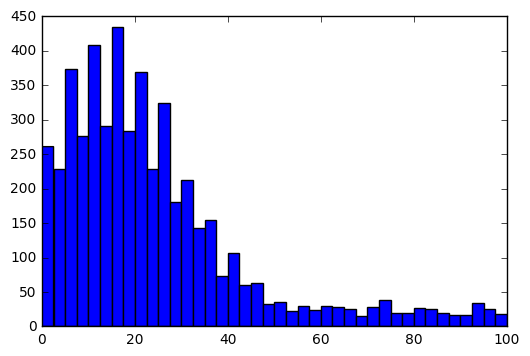

In [234]:
final_top = gen_top(True)

In [235]:
def gen_bot(show=False):
    # mean and standard deviation
    mu = np.random.randint(128, 256)
    sigma = np.random.randint(10, 100)
    print(mu)
    print(sigma)
    bot = np.random.normal(mu, sigma, 5000)

    # count, bins, ignored = plt.hist(bot, 40)
    # plt.show()

    count = 0
    real_bot = []
    for element in bot:
        if element < 0 or element > 255:
            count += 1
        else:
            real_bot.append(int(element))
    print count
    # print(real_bot)

    real_bot = np.array(real_bot)

    remainder = np.random.uniform(100, 256, count)
    # print(remainder)

    final_bot = np.concatenate((real_bot, remainder))

    if show == True:
        count, bins, ignored = plt.hist(final_bot, 40)
        plt.show()
    
    return final_bot

193
23
18


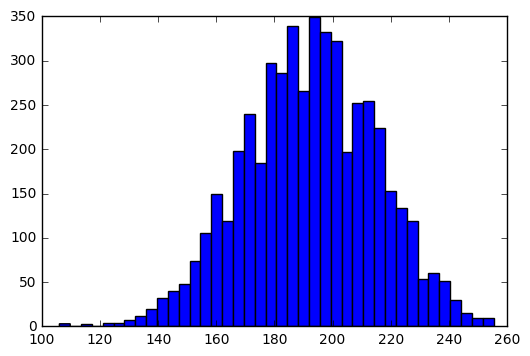

In [236]:
final_bot = gen_bot(True)

In [238]:
def gen_easy1():
    top = gen_top()
    bot = gen_bot()
    
    sim_im_flat = np.concatenate((top, bot))
    
    sim_im = cv2.imread('images/test.png')
    sim_im = cv2.cvtColor(sim_im, cv2.COLOR_BGR2GRAY)

    sim_im = sim_im[0:100,0:100]
    
    for i in range(0, 50):
        for j in range(0, 100):
            sim_im[i, j] = sim_im_flat[i * 100 + j]

    for i in range(50, 100):
        for j in range(0, 100):
            sim_im[i, j] = sim_im_flat[i * 100 + j]
            
    return sim_im

In [239]:
sim_im_flat = np.concatenate((final_top, final_bot))

In [240]:
print(sim_im_flat.shape)

(10000,)


In [241]:
sim_im = cv2.imread('images/test.png')
sim_im = cv2.cvtColor(sim_im, cv2.COLOR_BGR2GRAY)

sim_im = sim_im[0:100,0:100]

In [242]:
# sim_im = np.zeros((100, 100), dtype=np.int)

for i in range(0, 50):
    for j in range(0, 100):
        sim_im[i, j] = sim_im_flat[i * 100 + j]
        
for i in range(50, 100):
    for j in range(0, 100):
        sim_im[i, j] = sim_im_flat[i * 100 + j]

### Simulation Image

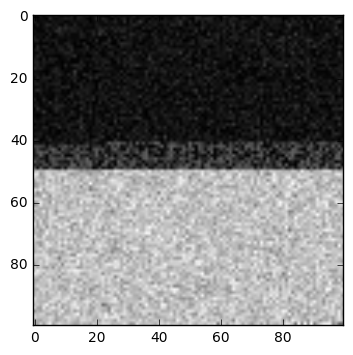

In [243]:
plt.imshow(sim_im, cmap='gray')
plt.show()

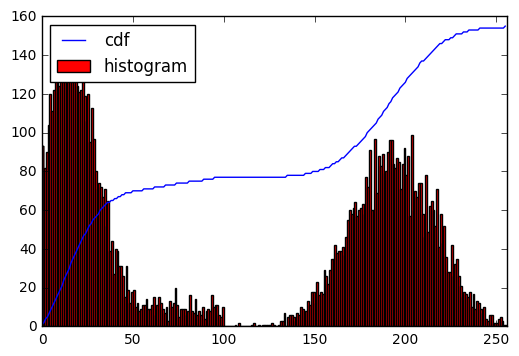

In [244]:
hist,bins = np.histogram(sim_im.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(sim_im.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

### Applying clahe

In [245]:
# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE()
sim_im_clahe = clahe.apply(sim_im)

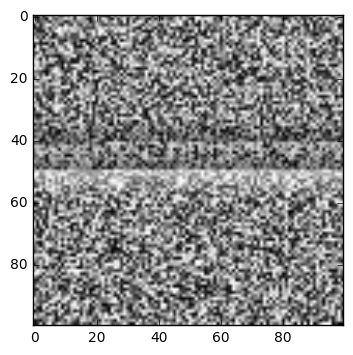

In [246]:
plt.imshow(sim_im_clahe, cmap='gray')
plt.show()

In [247]:
sim_im_top = sim_im[0:50, 0:100]
sim_im_bot = sim_im[50:100, 0:100]

clahe_top = sim_im_clahe[0:50, 0:100]
clahe_bot = sim_im_clahe[50:100, 0:100]

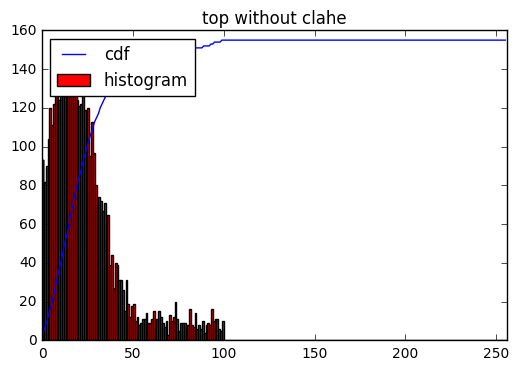

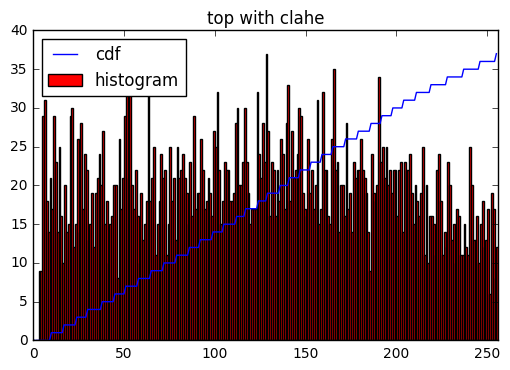

In [249]:
plot_hist(sim_im_top, 'top without clahe')
plot_hist(clahe_top, 'top with clahe')

#### Analysis
**Analysis**
As you can see, the histogram is more evenly spread, thus the slope of the cdf is lower.

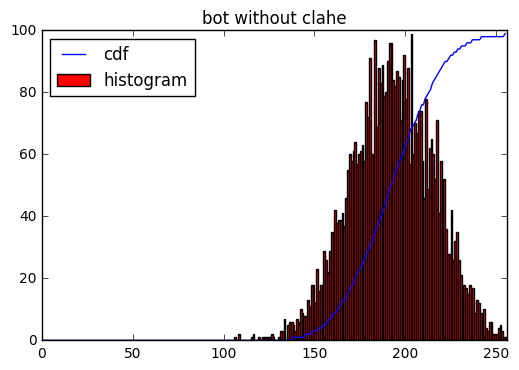

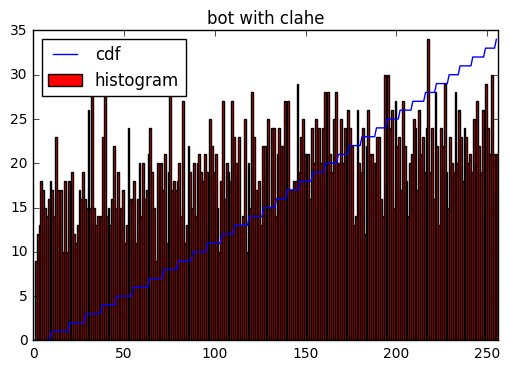

In [250]:
plot_hist(sim_im_bot, 'bot without clahe')
plot_hist(clahe_bot, 'bot with clahe')

In [251]:
histeq = cv2.equalizeHist(sim_im)

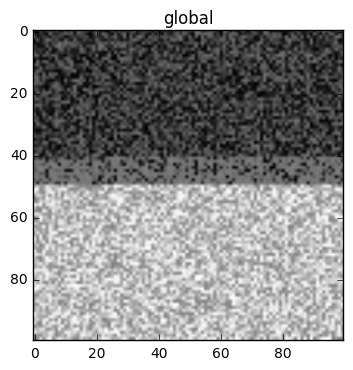

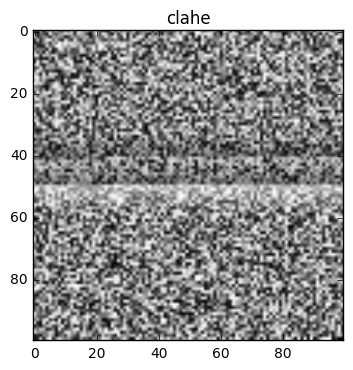

In [253]:
plt.imshow(histeq, cmap='gray')
plt.title('global')
plt.show()

plt.imshow(sim_im_clahe, cmap='gray')
plt.title('clahe')
plt.show()

### Comparison to Global histogram equalization

In the above two images, you can see that the image after clahe reveals more of the details of the image than the global histogram equalization one does.

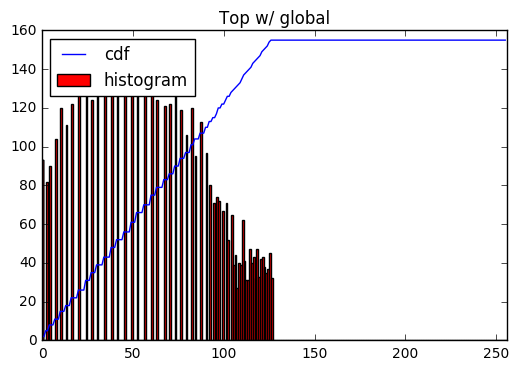

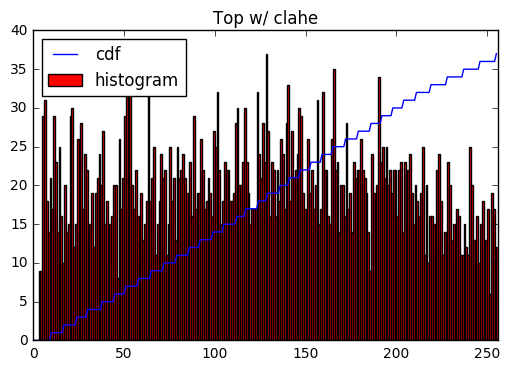

In [256]:
histeq_top = histeq[0:50, 0:100]
histeq_bot = histeq[50:100, 0:100]

plot_hist(histeq_top, 'Top w/ global')
plot_hist(clahe_top, 'Top w/ clahe')

## Real data

In [10]:
%matplotlib inline
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata
import numpy as np
import cv2
import nibabel as nib

In [ ]:
inToken = "Fear199"

inImg = imgDownload(inToken, resolution=5)
# imgShow(inImg, vmax=500)

inImg_backup = img_copy(inImg)

In [196]:
inImg = img_copy(inImg_backup)

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)
(0.01872, 0.01872, 0.005)


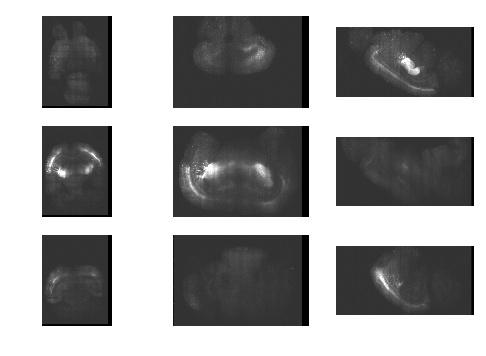

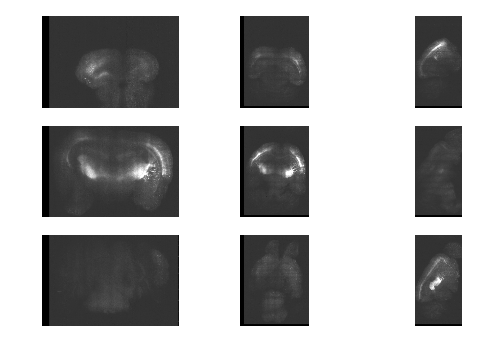

100


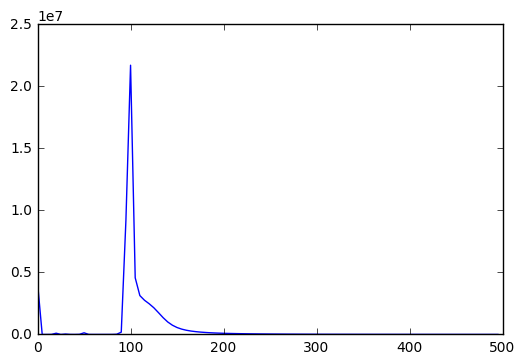

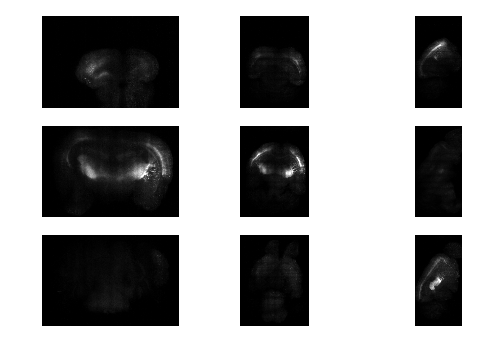

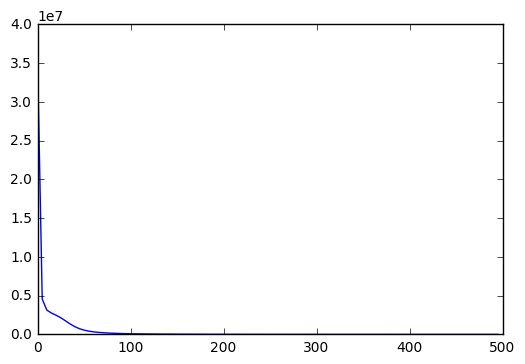

In [197]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)
# imgShow(refImg, vmax=500)

# refAnnoImg = imgDownload(refToken, channel="annotation")
# imgShow(refAnnoImg, vmax=1000)

print(refImg.GetSpacing())
print(inImg.GetSpacing())

# Respacing according to the reference image
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
imgShow(inImg, vmax=500)

# Reorienting
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

# Thresholding
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

counts = np.bincount(values)
maximum = np.argmax(bins)
print(maximum)
# print(counts)

lowerThreshold = maximum
upperThreshold = sitk.GetArrayFromImage(inImg).max()+1


# 3, 2, 1
inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
imgShow(inImg, vmax = 500)

(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

# Saving image
location = "img/" + 'Fear199' + "_thresh.nii"
imgWrite(inImg, str(location))

In [104]:
path = "img/Fear199_thresh.nii"

real_im = nib.load(path)
real_im = real_im.get_data()
img = real_im[:,:,:]

img = np.int16(255 * (np.float32(img) / np.float32(np.max(img))))


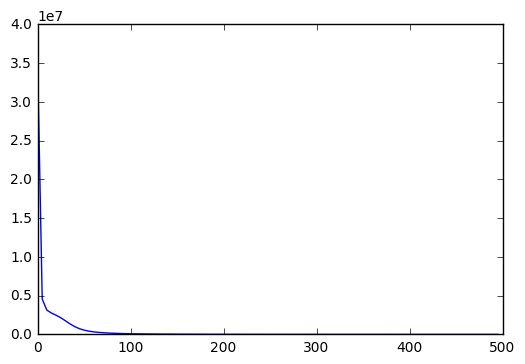

In [82]:
(values, bins) = np.histogram(real_im, bins=100, range=(0,256))
plt.plot(bins[:-1], values)

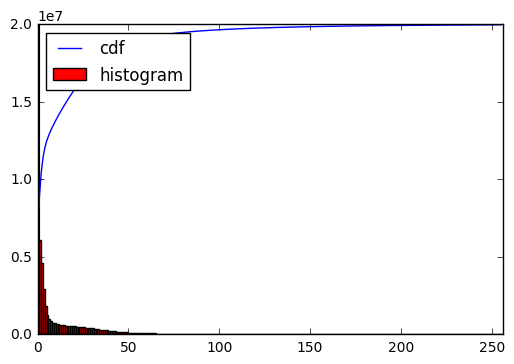

In [81]:
plot_hist(real_im)

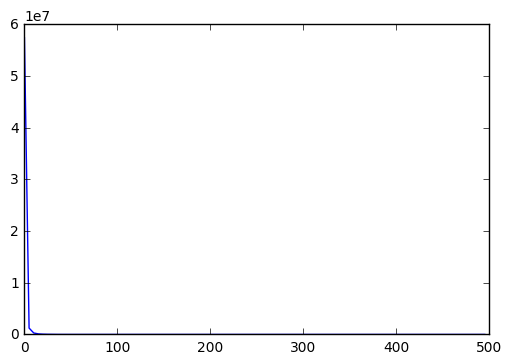

In [20]:
(values, bins) = np.histogram(img, bins=100, range=(0,500))
plt.plot(bins[:-1], values)

In [22]:
print(real_im.shape)

(405, 272, 537)


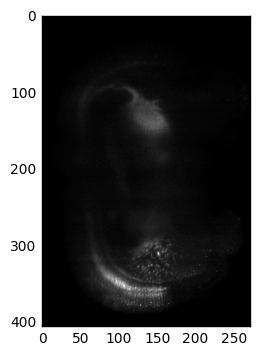

In [57]:
real_slice = real_im[:,:,250]

plt.imshow(real_slice, cmap='gray')
plt.show()

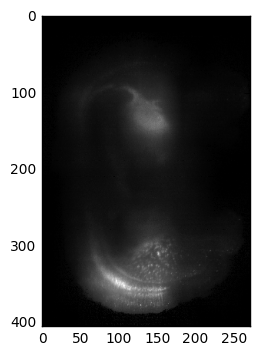

In [76]:
# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=44.0, tileGridSize=(10,10))
slice_clahe = clahe.apply(real_slice)

plt.imshow(slice_clahe, cmap='gray')
plt.show()

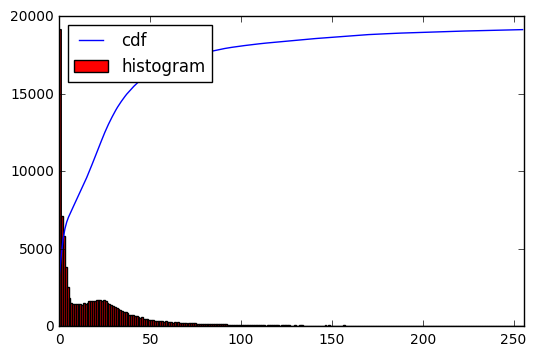

In [80]:
plot_hist(real_slice)

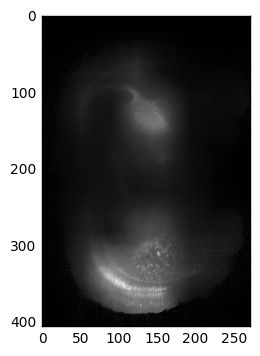

In [71]:
# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(8,8))
slice_clahe = clahe.apply(real_slice)

plt.imshow(slice_clahe, cmap='gray')
plt.show()

In [90]:
def img_copy(img):
    """
    Returns a copy of the input image
    """
    return sitk.Image(img)

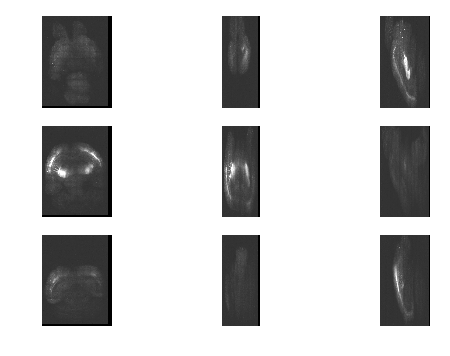

In [91]:
inToken = "Fear199"

inImg = imgDownload(inToken, resolution=5)
imgShow(inImg, vmax=500)

inImg_backup = img_copy(inImg)

In [194]:
inImg = img_copy(inImg_backup)

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)
(0.01872, 0.01872, 0.005)


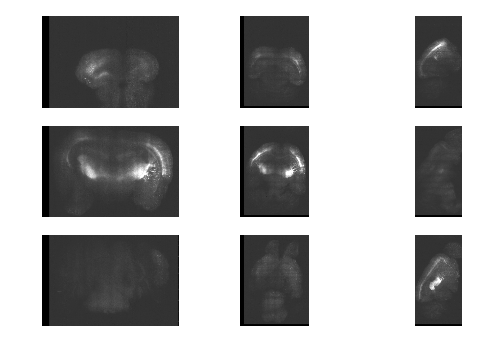

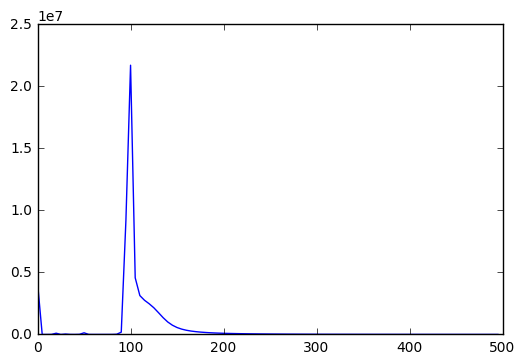

In [195]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)
# imgShow(refImg, vmax=500)

# refAnnoImg = imgDownload(refToken, channel="annotation")ii
# imgShow(refAnnoImg, vmax=1000)

print(refImg.GetSpacing())
print(inImg.GetSpacing())

# Respacing according to the reference image
inImg = imgResample(inImg, spacing=refImg.GetSpacing())
# imgShow(inImg, vmax=500)

# Reorienting
inImg = imgReorient(inImg, "LAI", "RSA")
imgShow(inImg, vmax=500)

# Thresholding
(values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

# counts = np.bincount(values)
# maximum = np.argmax(bins)
# print(maximum)
# # print(counts)

# lowerThreshold = maximum
# upperThreshold = sitk.GetArrayFromImage(inImg).max()+1


# # 3, 2, 1
# inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
# imgShow(inImg, vmax = 500)

# (values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
# plt.plot(bins[:-1], values)

# Saving image
location = "img/" + 'Fear199' + ".nii"
imgWrite(inImg, str(location))

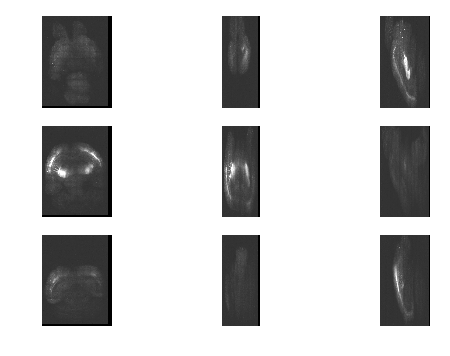

In [193]:
imgShow(inImg_backup, vmax = 500)

In [121]:
path = "img/Fear199.nii"

real_im = nib.load(path)
real_im = real_im.get_data()
img = real_im[:,:,:]

img = np.int16(255 * (np.float32(img) / np.float32(np.max(img))))

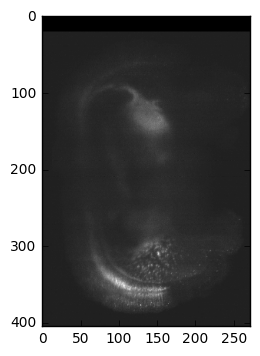

In [122]:
real_slice = real_im[:,:,250]

plt.imshow(real_slice, cmap='gray')
plt.show()

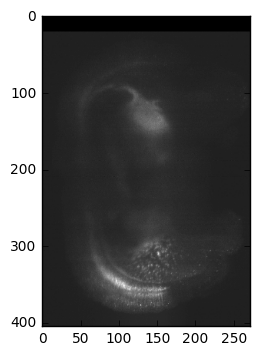

In [128]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
slice_clahe = clahe.apply(real_slice)

plt.imshow(slice_clahe, cmap='gray')
plt.show()

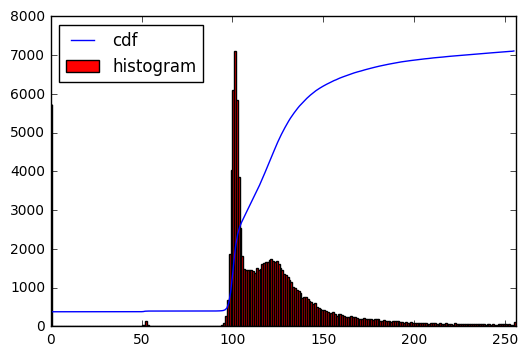

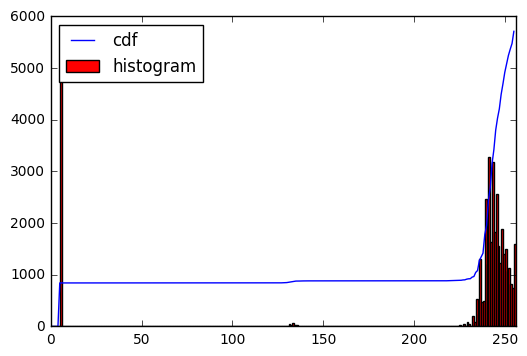

In [129]:
plot_hist(real_slice)
plot_hist(slice_clahe)

### Real data analysis: Fear199

Now it becomes much easier to identify the brightpoints in the image because the points representing the background (intensity of 0) are very far from the ones representing the actual brain

In [117]:
path = "img/Fear199_thresh.nii"

real_im_t = nib.load(path)
real_im_t = real_im_t.get_data()
img = real_im[:,:,:]

img = np.int16(255 * (np.float32(img) / np.float32(np.max(img))))

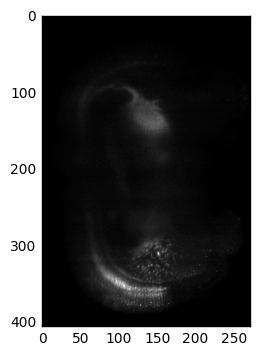

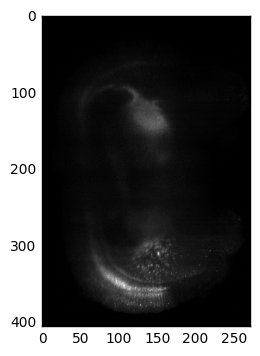

In [131]:
real_slice_t = real_im_t[:,:,250]

plt.imshow(real_slice_t, cmap='gray')
plt.show()

# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# clahe = cv2.createCLAHE(clipLimit=44.0, tileGridSize=(10,10))
slice_clahe_t = clahe.apply(real_slice_t)

plt.imshow(slice_clahe_t, cmap='gray')
plt.show()

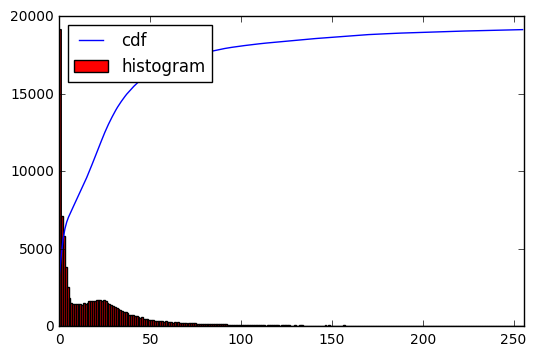

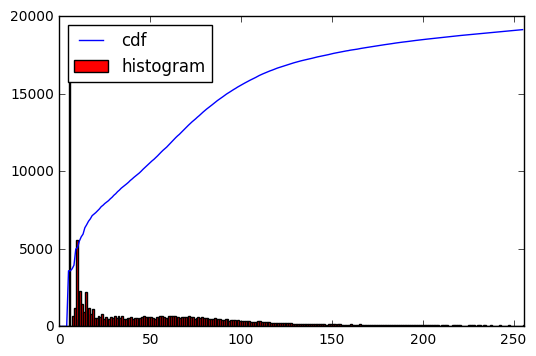

In [132]:
plot_hist(real_slice_t)
plot_hist(slice_clahe_t)

### Testing on Aut1367

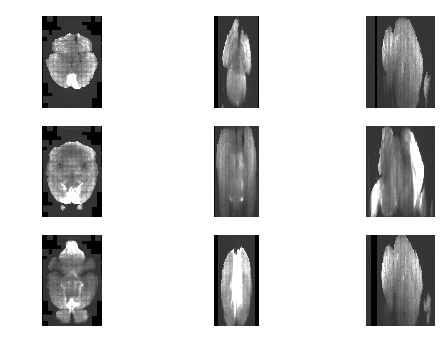

In [133]:
inToken = "Aut1367"

autImg = imgDownload(inToken, resolution=5)
imgShow(autImg, vmax=500)

autImg_backup = img_copy(autImg)

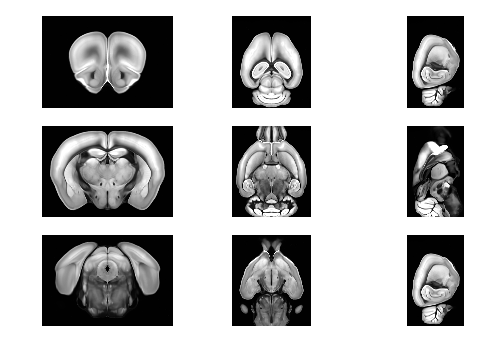

(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)
(0.024999999999999998, 0.024999999999999998, 0.024999999999999998)


In [137]:
refToken = "ara_ccf2"
refImg = imgDownload(refToken)
imgShow(refImg, vmax=500)

# refAnnoImg = imgDownload(refToken, channel="annotation")ii
# imgShow(refAnnoImg, vmax=1000)

print(refImg.GetSpacing())
print(inImg.GetSpacing())

In [261]:
autImg = img_copy(autImg_backup)
# imgShow(autImg, vmax=500)

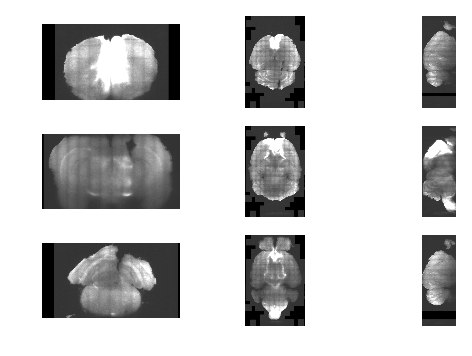

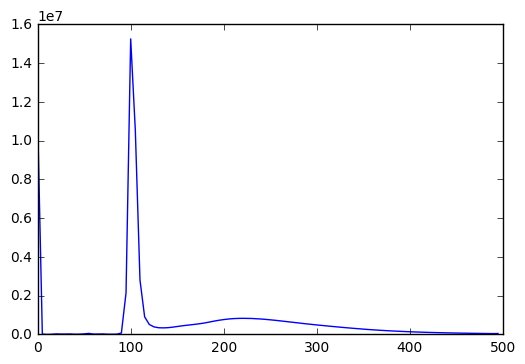

In [262]:
# Respacing according to the reference image
autImg = imgResample(autImg, spacing=refImg.GetSpacing())
# imgShow(inImg, vmax=500)

# Reorienting
autImg = imgReorient(autImg, "RPS", "RSA")
imgShow(autImg, vmax=500)

# Thresholding
(values, bins) = np.histogram(sitk.GetArrayFromImage(autImg), bins=100, range=(0,500))
plt.plot(bins[:-1], values)

# counts = np.bincount(values)
# maximum = np.argmax(bins)
# print(maximum)
# # print(counts)

# lowerThreshold = maximum
# upperThreshold = sitk.GetArrayFromImage(inImg).max()+1


# # 3, 2, 1
# inImg = sitk.Threshold(inImg,lowerThreshold,upperThreshold,lowerThreshold) - lowerThreshold
# imgShow(inImg, vmax = 500)

# (values, bins) = np.histogram(sitk.GetArrayFromImage(inImg), bins=100, range=(0,500))
# plt.plot(bins[:-1], values)

# Saving image
location = "img/" + 'Aut1367' + ".nii"
imgWrite(autImg, str(location))

In [263]:
path = "img/Aut1367.nii"

aut_im = nib.load(path)
aut_im = aut_im.get_data()
print(aut_im.shape)
# img = real_im[:,:,:]

# img = np.int16(255 * (np.float32(img) / np.float32(np.max(img))))

(446, 245, 683)


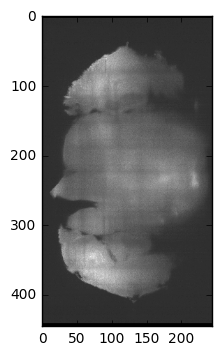

In [264]:
aut_slice = aut_im[:,:,400]

plt.imshow(aut_slice, cmap='gray')
plt.show()

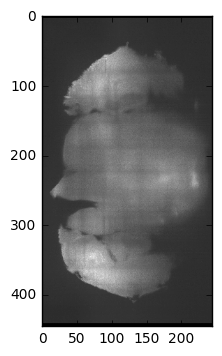

In [265]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
aut_slice_clahe = clahe.apply(aut_slice)

plt.imshow(aut_slice_clahe, cmap='gray')
plt.show()

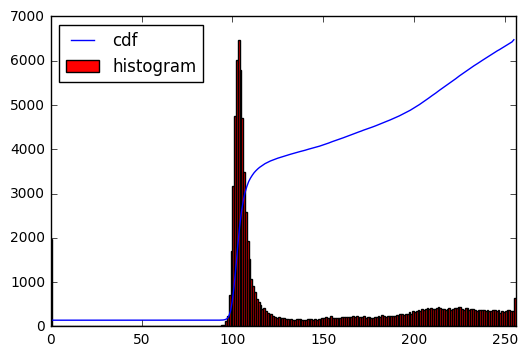

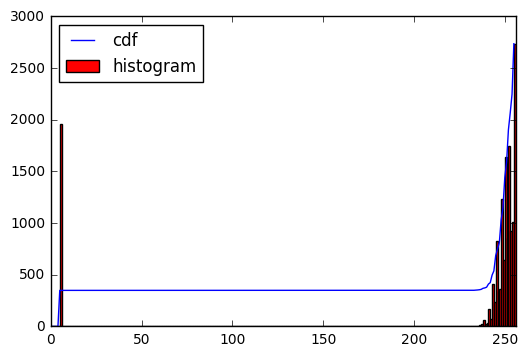

In [266]:
plot_hist(aut_slice)
plot_hist(aut_slice_clahe)

## Miscellaneous testing

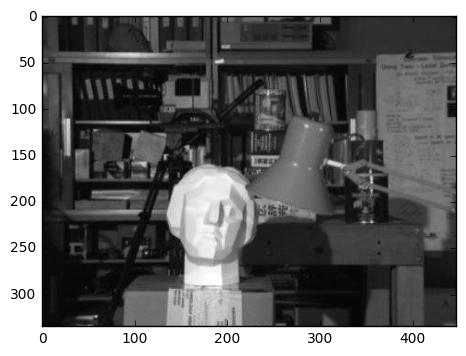

In [104]:
im = cv2.imread('images/test.png')

# plt.imshow(im)
# plt.show()

im_disp = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_disp)
plt.show()

In [105]:
print(im)
print(im.shape)

[[[46 46 46]
  [48 48 48]
  [46 46 46]
  ..., 
  [41 41 41]
  [40 40 40]
  [39 39 39]]

 [[50 50 50]
  [53 53 53]
  [51 51 51]
  ..., 
  [39 39 39]
  [38 38 38]
  [37 37 37]]

 [[44 44 44]
  [46 46 46]
  [44 44 44]
  ..., 
  [39 39 39]
  [38 38 38]
  [37 37 37]]

 ..., 
 [[12 12 12]
  [12 12 12]
  [12 12 12]
  ..., 
  [69 69 69]
  [69 69 69]
  [68 68 68]]

 [[12 12 12]
  [12 12 12]
  [12 12 12]
  ..., 
  [81 81 81]
  [80 80 80]
  [78 78 78]]

 [[ 9  9  9]
  [ 9  9  9]
  [ 9  9  9]
  ..., 
  [85 85 85]
  [85 85 85]
  [83 83 83]]]
(335, 448, 3)


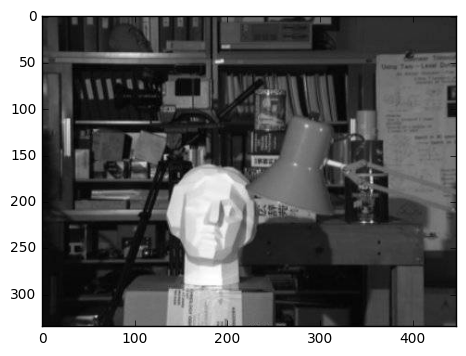

In [106]:
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# plt.axis("off")
plt.imshow(im_gray, cmap='gray')
plt.show()

In [108]:
print(im_gray)
print(im_gray.shape)

[[46 48 46 ..., 41 40 39]
 [50 53 51 ..., 39 38 37]
 [44 46 44 ..., 39 38 37]
 ..., 
 [12 12 12 ..., 69 69 68]
 [12 12 12 ..., 81 80 78]
 [ 9  9  9 ..., 85 85 83]]
(335, 448)


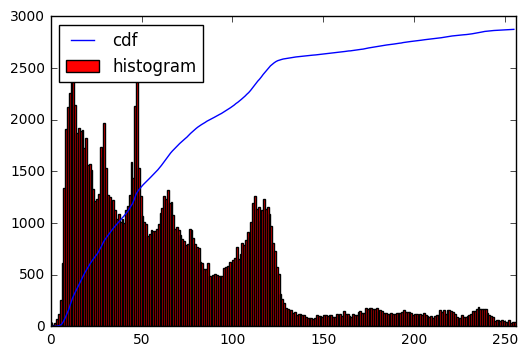

In [109]:
hist,bins = np.histogram(im_gray.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(im_gray.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [19]:
# create a CLAHE object (Arguments are optional).
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe = cv2.createCLAHE()
im_clahe = clahe.apply(im_gray)

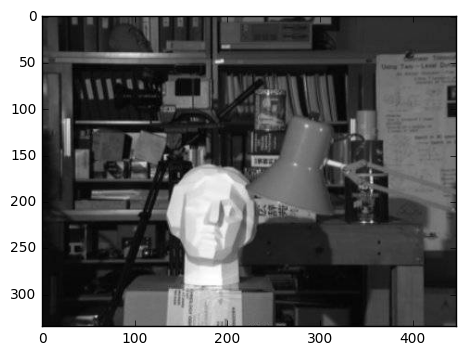

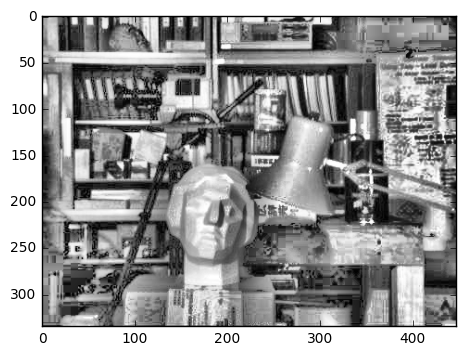

In [20]:
plt.imshow(im_gray, cmap='gray')
plt.show()

plt.imshow(im_clahe, cmap='gray')
plt.show()

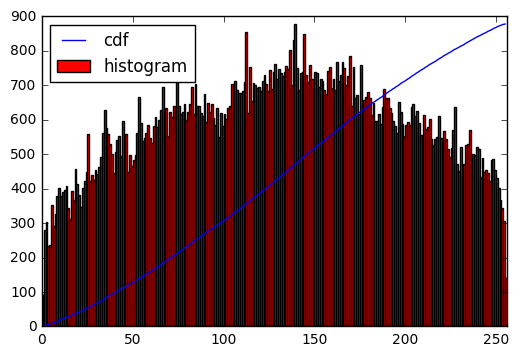

In [21]:
hist,bins = np.histogram(im_clahe.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(im_clahe.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [52]:
print(real_im.shape)

(405, 272, 537)


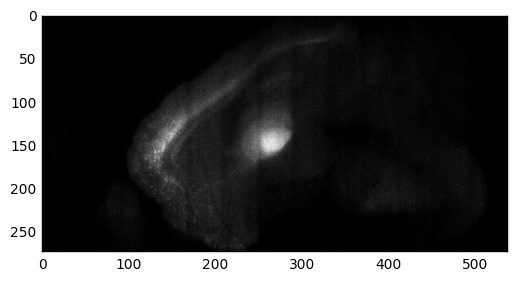

In [50]:
real_slice = real_im[150,:,:]

plt.imshow(real_slice, cmap='gray')
plt.show()

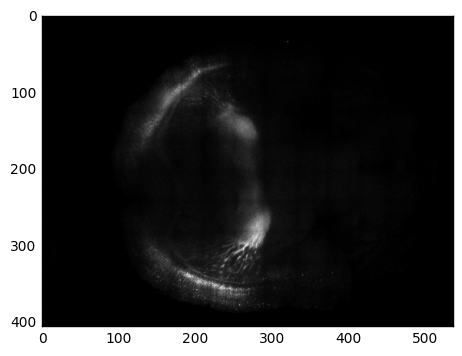

In [49]:
real_slice = real_im[:,150,:]

plt.imshow(real_slice, cmap='gray')
plt.show()

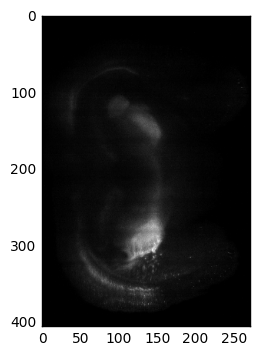

In [51]:
real_slice = real_im[:,:,275]

plt.imshow(real_slice, cmap='gray')
plt.show()

In [ ]:
img_grey = np.array(imgflat * 255, dtype = np.uint8)